In [1]:

'''
MASTER SCRIPT

This a new script to analysise the following
1. Density profile
2. Transonic radius and nonthermal velocity at r_c
3. Energy estimate
4. B_field
5. Mass-to_flux ratio
6. B_field error
7. Mass-to-flux error

Author   : Sayantan Auddy
Created  : 18 September 2017
Modified : 23 April 2018

Modified : MAy 7 2018 added the enegy estimate but without the errors

Modifies : 30 July to change the plotting radius till rc
         : added error to rc and beta in function and cfs file,
         : added error to the total mass estimate
         
Modified : 21 August to add the percentage increase in B2 over B1 and for B1 over B1_u1 (diffenrent \beta)        

'''

'''
Output data files : Magne

'''

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
from scipy import optimize
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy import integrate
import os.path
from decimal import Decimal # to print in scientific notation
import CFS_functions as cfs
import function as mf

In [2]:
# parameters that are needed.
distinpc = 120.0
pc = 3.0857e+18 # cm 
AU = 1.496e+13  # cm
amu = 1.6605402e-24 # g
mu = 2.33*amu
mperH2= 2.8* amu
Msun=1.9891e+33 # g
G = 6.67259e-8 # cm3 g-1 s-2
# 1 Gauss = g^(1/2) * cm^{-1/2}* s^-1
##

[  1.33454701e+23   4.97165228e+01   8.77456126e-01]
[  9.88658658e+20   1.90880453e+01   4.54170643e-01]


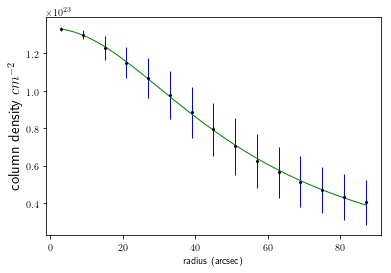

In [3]:
## fitting the plummer type fucntion to the column density profile
# fileName = "./columndensity_data/H-MM1_column_density.dat"
# fileName = "./columndensity_data/H-MM2_column_density.dat"
# fileName = "./columndensity_data/OpHCN_column_density.dat"
fileName = "./columndensity_data/OpH-C_column_density.dat"
# fileName = "./columndensity_data/OpH-E_column_density.dat"
# fileName = "./columndensity_data/OpH-X_column_density.dat"
# fileName = "./columndensity_data/OpHFE_column_density.dat"
radius,columndensity,columndensityerror = cfs.readcolumndensity(fileName)

vGuess = [np.max(columndensity),24,1]
vPars, aCova = optimize.curve_fit(cfs.plummerfunction, radius, columndensity, vGuess,sigma=columndensityerror,absolute_sigma=True)
print(vPars)
unc = np.sqrt(np.diag(aCova))
print(unc)
xFine = np.linspace(radius[0],radius[len(radius)-1], num=100, endpoint=True)
plt.errorbar(radius,columndensity,yerr=columndensityerror,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
plt.plot(xFine, cfs.plummerfunction(xFine,*vPars), 'g-', lw=1) # Fitted parameters
plt.xlabel('radius (arcsec)')
plt.ylabel(r'column density $cm^{-2}$',fontsize=15)
plt.show()

n_flat= 689414.483362 cm-3
r_flatinpc= 0.0289241020879
index= 1.37745612594


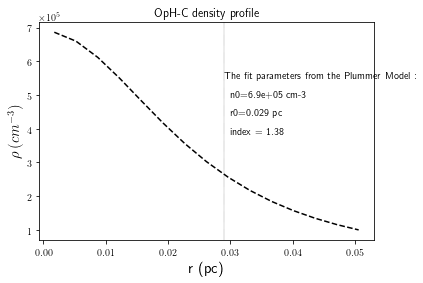

[ 0.00174534  0.00523602  0.00872671  0.01221739  0.01570807  0.01919876
  0.02268944  0.02618012  0.0296708   0.03316149  0.03665217  0.04014285
  0.04363354  0.04712422  0.0506149 ]


In [4]:
### Density Profile
n_flat,r_flatinpc,index= cfs.plummerparameter(vPars[0],vPars[1],vPars[2])
print("n_flat=",n_flat,"cm-3")
print("r_flatinpc=",r_flatinpc)
print("index=" ,index)
radiusinpc = radius*distinpc*AU/pc
n = n_flat/(1+(radiusinpc/r_flatinpc)**2)**index 
outputfilename =  fileName[21]+fileName[22]+fileName[23]+fileName[24]+fileName[25]
save_path = './figures/'
outputfigureden = os.path.join(save_path, outputfilename + '_density' +".eps")
ranger1 = max(n)-0.20*max(n)
ranger2 = ranger1 -0.08*max(n)
ranger3 = ranger2 -0.08*max(n)
ranger4 = ranger3 -0.08*max(n)
plt.plot(radiusinpc,n,'k--')
plt.ylabel(r'$ \rho \, (cm^{-3})$', fontsize=15)
plt.xlabel(r'r (pc)',fontsize=15)
plt.axvline(x=r_flatinpc,linewidth=0.4,color='k',ls=':')
plt.text(r_flatinpc,ranger1, 'The fit parameters from the Plummer Model :' )
plt.text(r_flatinpc+0.001,ranger2, 'n0=%s   cm-3'% '%.1e' % Decimal(n_flat) )
plt.text(r_flatinpc+0.001,ranger3, 'r0=%s   pc'% round(r_flatinpc,3) )
plt.text(r_flatinpc+0.001,ranger4, 'index = %s'% round(index,2) )
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,2))
plt.title(outputfilename +' density profile')
# plt.yscale('log')
plt.savefig(outputfigureden,format='eps',dpi=300)
plt.show()
print(radiusinpc)

In [5]:
save_path1 = './errors/'
save_path2 = './magnetic_field_data/'
save_path3 = './plummer_fit_data/'
save_path4 = './energy_data/' 

energydata_file = os.path.join(save_path4, outputfilename + 'energy' +".dat")

plummerfit_file = os.path.join(save_path3, outputfilename + 'plummerfit' +".dat")

outputm2ferrorsk1 = os.path.join(save_path1, outputfilename + '_masstoflux_k1' +".dat")
outputm2ferrorsk2 = os.path.join(save_path1, outputfilename + '_masstoflux_k2' +".dat")

outputm2f = os.path.join(save_path2, outputfilename + '_m2f' +".dat")


outputBerrorsk1 = os.path.join(save_path1, outputfilename + '_berror_k1' +".dat")
outputBerrorsk2 = os.path.join(save_path1, outputfilename + '_berror_k2' +".dat")

outputB = os.path.join(save_path2, outputfilename + '_B_field' +".dat")


In [6]:
from uncertainties import ufloat
eta = ufloat(vPars[2],unc[2])+0.5
print(eta)
r_fl = ufloat(vPars[1],unc[1])*distinpc*AU
# print(r_flat)
print(r_fl/pc)
def Ap(u):
    return 1/ (1+u**2)**index
def bounds_u():
    return [-2500, 2500]
result = integrate.nquad(Ap, [bounds_u])
    
n_fl=ufloat(vPars[0],unc[0])/r_fl/result[0]
print(n_fl)
Plummermodel_error = [eta.s,r_fl.s/pc,n_fl.s]
print(Plummermodel_error)
Dataplummer = np.column_stack((n_flat,Plummermodel_error[2],r_flatinpc,Plummermodel_error[1],index,Plummermodel_error[0]))

np.savetxt(plummerfit_file,Dataplummer, fmt=('%5.3e','%5.3e','%5.3e','%5.3e','%5.3e','%5.3e'))

1.4+/-0.5
0.029+/-0.011
(6.9+/-2.6)e+05
[0.45417064318408124, 0.01110505200965199, 264741.45105629304]


In [7]:
# reading the transonic radius and the vel disper from file

filenametrasonicradius = "./transonic_data/" + fileName[21]+fileName[22]+fileName[23]+fileName[24]+fileName[25]+'rt.txt'
filenametrasonicsigma  = "./transonic_data/" + fileName[21]+fileName[22]+fileName[23]+fileName[24]+fileName[25]+'sigmat.txt'
r_cc_file = mf.readfilefortransonicdata(filenametrasonicradius)
r_c = np.asarray(r_cc_file)
rc = r_c*distinpc*4.84814e-6 # in pc 
sigma_NT_C_file = mf.readfilefortransonicdata(filenametrasonicsigma)
print(sigma_NT_C_file)
sigma_NT_C = np.asarray(sigma_NT_C_file)*(10**5)
print("sigma_NC=",sigma_NT_C,"cm/s \n","rc =",rc,"pc")
#### magnetic field with error ### 
# sigma_NT_C = 24589.090
# rc = 0.05
beta = 0.5
beta_ul = 0.8
nc = n_flat/(1+(rc/r_flatinpc)**2)**index
print("nc=",nc)
B_cc = (sigma_NT_C  *(4* np.pi*mu* nc)**(.5))/beta
B_cc_ul = (sigma_NT_C  *(4* np.pi*mu* nc)**(.5))/beta_ul
print("B_cc =" , B_cc," Gauss")

## changes made on 30July to plot just inside the radius

radiusinsidecore = np.linspace(0,rc,50)  
n_insidecore = n_flat/(1+(radiusinsidecore/r_flatinpc)**2)**index 
B1= (B_cc *(n_insidecore/nc)**(1/2))*10**6
B1_ul= (B_cc_ul *(n_insidecore/nc)**(1/2))*10**6

# print(B1)
B2 = (B_cc *(n_insidecore/nc)**(2/3))*10**6 
B2_ul = (B_cc_ul *(n_insidecore/nc)**(2/3))*10**6 
print(0.1*sigma_NT_C)

## this column saves the radius, n and both the mag fields Added 5 May18
DataOutB = np.column_stack((radiusinsidecore,n_insidecore,B1,B2,B1_ul,B2_ul))

np.savetxt(outputB, DataOutB, fmt=('%5.3e','%5.3e','%5.3e','%5.3e','%5.3e','%5.3e'))
print(radiusinsidecore)
# print(B1)


[0.22983553755327335]
sigma_NC= [ 22983.55375533] cm/s 
 rc = [ 0.04515263] pc
nc= [ 125870.97839708]
B_cc = [ 0.00011371]  Gauss
[ 2298.35537553]
[ 0.          0.00092148  0.00184296  0.00276445  0.00368593  0.00460741
  0.00552889  0.00645038  0.00737186  0.00829334  0.00921482  0.0101363
  0.01105779  0.01197927  0.01290075  0.01382223  0.01474372  0.0156652
  0.01658668  0.01750816  0.01842964  0.01935113  0.02027261  0.02119409
  0.02211557  0.02303706  0.02395854  0.02488002  0.0258015   0.02672298
  0.02764447  0.02856595  0.02948743  0.03040891  0.0313304   0.03225188
  0.03317336  0.03409484  0.03501633  0.03593781  0.03685929  0.03778077
  0.03870225  0.03962374  0.04054522  0.0414667   0.04238818  0.04330967
  0.04423115  0.04515263]


In [10]:
## added on 12 March to calculate the mean magnetic field of the core
print(rc,B_cc,r_flatinpc,n_flat,nc,index,2/3)
mean_magnetic_field = mf.mean_magnetic_field(rc,B_cc,r_flatinpc,n_flat,nc,index,2/3)
print("mean field=",mean_magnetic_field*10**6, " 10^-6 Gauss" )

[ 0.04515263] [ 0.00011371] 0.0289241020879 689414.483362 [ 125870.97839708] 1.37745612594 0.6666666666666666
mean field= 166.21704848532073  10^-6 Gauss


In [12]:
## we need to add a column to estimate the percentage increase between B1 and B2 and B1 and B1_u1 at any particular radius 
## lets say at r = 0.01 pc for H-MM1. 
# Date added = 21 August 2018
r01 = 0.01

n_r01 = n_flat/(1+(r01/r_flatinpc)**2)**index
print("nc=",n_r01)

B1_r01= (B_cc *(n_r01/nc)**(1/2))*10**6
B1_ul_r01= (B_cc_ul *(n_r01/nc)**(1/2))*10**6

print("B1=",B1_r01, "B1_mod=", B1_ul_r01)
B2_r01 = (B_cc *(n_r01/nc)**(2/3))*10**6 
B2_ul_r01 = (B_cc_ul *(n_r01/nc)**(2/3))*10**6 
print("B2=",B2_r01,"B2_mod=",B2_ul_r01)
percentageincrease_B2andB1 = (B2_r01 - B1_r01)/B1_r01
# percentagedecrease_B1_u1andB1 = (B1_r01 - B1_ul_r01)/B1_r01
# percentagedecrease_B2_u1andB2 = (B2_r01 - B2_ul_r01)/B2_r01
#percentagedecrease_B2_u1andB2 = (B_cc - B_cc_ul)/B_cc
print("B2 increase by", percentageincrease_B2andB1)
# print("B1_u1dec_B1",percentagedecrease_B1_u1andB1)
#print("B2_u1dec_B2",percentagedecrease_B2_u1andB2)

nc= 413736.594888
B1= [ 220.56775031] B1_mod= [ 137.85484394]
B2= [ 370.62870664] B2_mod= [ 231.64294165]
B2 increase by [ 0.68033952]


In [13]:
## read the transonic data from the fil
fileNamevelocitydisprsion = "./data_sigma/"+fileName[21]+fileName[22]+fileName[23]+fileName[24]+fileName[25]+"_sigmav.dat"
fp = open (fileNamevelocitydisprsion,'r')
## Declaring an empty list to store the data from the .dat file
radius1_list = []  # units cm 
vthermal_list= []      # units cm^{-3}
vnontherma_list = []

## Reading the data from a .dat file line by line
for line in fp:
    t = line.strip().split()  
    radius1_list.append(float(t[0]))
    vthermal_list.append(float(t[1]))
    vnontherma_list.append(float(t[2])) 
    
fp.close()  
vthermal = np.asarray(vthermal_list)
vnonthermal = np.asarray(vnontherma_list)
# radiusinpc = np.asarray(radius1_list)*distinpc*4.84814e-6 # in pc
# print(radiusinpc)
# print(vthermal)

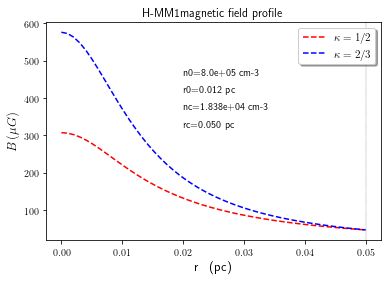

In [14]:
rangey1 = max(B2)-0.20*max(B2)
rangey2 = rangey1 -0.08*max(B2)
rangey3 = rangey2 - 0.08*max(B2)
rangey4 = rangey3 -0.08*max(B2)
plt.plot(radiusinsidecore,B1,'r--',label=r'$\kappa=1/2$')
plt.plot(radiusinsidecore,B2,'b--',label=r'$\kappa=2/3$')
plt.legend(numpoints=1,fancybox=True,shadow=True,fontsize=11,loc=1)
plt.ylabel(r'$ B \, (\mu G)$', fontsize=13)
plt.xlabel(r'r \, (pc) ',fontsize=13)
plt.axvline(x=rc,linewidth=0.4,color='k',ls=':')
# plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma)) 
plt.text(0.02,rangey1, 
         'n0=%s   cm-3'% '%.1e' % Decimal(n_flat) )
plt.text(0.02,rangey2, 'r0=%s   pc'% round(r_flatinpc,3) )
plt.text(0.02,rangey3, 'nc=%s   cm-3'% '%.3e' % nc )
plt.text(0.02,rangey4, 'rc=%s   pc'% '%.3f' %(rc))
plt.title(outputfilename + 'magnetic field profile')
outputfiguremag = os.path.join(save_path, outputfilename + 'magfield' +".eps")
plt.savefig(outputfiguremag,format='eps',dpi=300)
plt.show()

In [ ]:
# # example of the distribution of the B field at any r
# # print( B_sigmaerror(index,r_flatinpc, n_flat, sigma_NT_C,0.1, k=1/2))
# Bmean,B_sigma,B_1quartile,B_3quartile = B_sigmaerror(index,r_flatinpc, n_flat, sigma_NT_C,0.01, k=2/3)
# # print(Bmean,B_sigma,B_1quartile,B_3quartile)
# plt.hist(Bmean)
# plt.show()
# plt.hist(B_1quartile)
# plt.show()

In [ ]:
Bk1_1quatile = []
Bk1_mean = []
Bk1_3quatile = []
Bk1_sigma_mean = []
Bk2_1quatile = []
Bk2_mean = []
Bk2_3quatile = []
Bk2_sigma_mean = []
N =100
# radius = np.linspace(0,0.06,N)
r = []
for j in range(0, len(radiusinsidecore), 1):
        r = radiusinsidecore[j]
        # k1 = 1/2
        Bmean_k1,B_sigma_k1,B_1quartile_k1,B_3quartile_k1 = cfs.B_sigmaerror(index,r_flatinpc, n_flat,Plummermodel_error,sigma_NT_C,rc,r, k=1/2)
        Bk1_1quatile_list = np.mean(B_1quartile_k1)
        Bk1_1quatile.append(Bk1_1quatile_list)
        Bk1_mean_list = np.mean(Bmean_k1)
        Bk1_mean.append(Bk1_mean_list)
        Bk1_3quatile_list = np.mean(B_3quartile_k1)
        Bk1_3quatile.append(Bk1_3quatile_list)
        Bk1_sigma_mean_list = np.mean(B_sigma_k1)
        Bk1_sigma_mean.append(Bk1_sigma_mean_list)
        
        # k2 = 2/3
        Bmean_k2,B_sigma_k2,B_1quartile_k2,B_3quartile_k2 = cfs.B_sigmaerror(index,r_flatinpc, n_flat,Plummermodel_error,sigma_NT_C,rc,r, k=2/3)
        Bk2_1quatile_list = np.mean(B_1quartile_k2)
        Bk2_1quatile.append(Bk2_1quatile_list)
        Bk2_mean_list = np.mean(Bmean_k2)
        Bk2_mean.append(Bk2_mean_list)
        Bk2_3quatile_list = np.mean(B_3quartile_k2)
        Bk2_3quatile.append(Bk2_3quatile_list)
        Bk2_sigma_mean_list = np.mean(B_sigma_k2)
        Bk2_sigma_mean.append(Bk2_sigma_mean_list)
        

DataOut1 = np.column_stack((Bk1_1quatile,Bk1_mean,Bk1_3quatile))
DataOut2 = np.column_stack((Bk2_1quatile,Bk2_mean,Bk2_3quatile))
np.savetxt(outputBerrorsk1, DataOut1, fmt=('%5.3e', '%5.3e', '%5.3e')) 
np.savetxt(outputBerrorsk2, DataOut2, fmt=('%5.3e', '%5.3e', '%5.3e')) 

In [ ]:
Bk1_1quatile,Bk1_mean,Bk1_3quatile = cfs.readmagneticfielderror(outputBerrorsk1)
Bk2_1quatile,Bk2_mean,Bk2_3quatile = cfs.readmagneticfielderror(outputBerrorsk2)


plt.figure(figsize=(6,4)) 
plt.plot(radiusinsidecore, B1,'r--',lw=0.8,label=r'$B\, \rm{for} \, k =1/2$')
plt.plot(radiusinsidecore, Bk1_mean,'r',lw=0.8,label=r'$B_{\rm{mean}}\, \rm{for}\, k =1/2$')
# Bk1errorplus = np.asanyarray(Bk1_mean) + np.asanyarray(Bk1_sigma_median)
# Bk1errorminus = np.asanyarray(Bk1_mean) - np.asanyarray(Bk1_sigma_median)
plt.fill_between(radiusinsidecore, Bk1_1quatile, Bk1_3quatile,color = 'aqua', alpha=0.5,interpolate=False)
# plt.fill_between(radius, Bk1errorplus, Bk1errorminus,facecolor='grey', alpha=1,interpolate=True)
plt.ylabel(r' B $(\mu G)$', fontsize=13)
plt.xlabel(r' r $(pc)$ ',fontsize=13)
plt.axvline(x=rc,linewidth=0.4,color='k',ls=':')
plt.plot(radiusinsidecore, B2,'m--',lw=0.8,label=r'$B \, \rm{for}\, k =2/3$')
plt.plot(radiusinsidecore, Bk2_mean,'m',lw=0.8,label=r'$B_{\rm{mean}} \, \rm{for} \,k =2/3$')
# Bk2errorplus = np.asanyarray(Bk2_mean) + np.asanyarray(Bk2_sigma_median)
# Bk2errorminus = np.asanyarray(Bk2_mean) - np.asanyarray(Bk2_sigma_median)
plt.fill_between(radiusinsidecore, Bk2_1quatile, Bk2_3quatile,color = 'aquamarine', alpha=0.5,interpolate=True)
# plt.plot(radiusinpc, Bk2_1quatile,'--', radiusinpc,Bk2_3quatile,'--',color = '#550caf', alpha=0.01)
# plt.fill_between(radius, Bk2errorplus, Bk2errorminus,facecolor='grey', alpha=0.1,interpolate=True)
# plt.plot(radius, Berrorplus, 'k--')
# plt.plot(radius, Berrorminus, 'k--')
plt.title(outputfilename +' magnetic field profile')
plt.legend(numpoints=1,fancybox=True,shadow=False,fontsize=11,loc=1)
save_path2 = './Plots_report/'
outputfiguremagerroe = os.path.join(save_path2, outputfilename + 'magfielderr' +".eps")
# plt.savefig(outputfiguremagerroe,format='eps',dpi=300)
plt.show()

In [ ]:
N = 20 

'''
note had to redefine the radius, the numerical masstoflux code can only take radius < r_c
so the new radius array has r_c as the maximum radius
'''

radiusinpcformass = np.linspace(0,rc,N)    
# radiusinpcformass = radiusinpc
length =len(radiusinpcformass)

total_mass = mf.numericalmassforanyindex(radiusinpcformass,rc,r_flatinpc,n_flat,index,length-1)
cumulative_mass =total_mass/Msun
print("total mass=",total_mass,"\ntotal mass in solar units= ",cumulative_mass)  # note this number will match with Jorma is use mperH2 instead of mu
print(max(radiusinpc))
print(r_flatinpc,rc,n_flat,nc,B_cc,index)

In [ ]:
# calculation of normalised mass-to-flux for k =2/3 and k =.5
## Howverm we are not using it for the paper as here we consider cylindrical flux tubes. 

# k1=1/2
# k2=2/3
# m2fk1_list = []       # this is for numerical k= .5
# m2fk2_list = []       # this is for numerical k= 2/3
# for i in range(1,N):
#     m2fnum0 = mf.numericalmasstoflux(radiusinpcformass,r_flatinpc,rc,n_flat,nc,B_cc,index,k1,i)
#     m2fk1_list.append(float(m2fnum0)) # in  grams
#     m2fnum1 = mf.numericalmasstoflux(radiusinpcformass,r_flatinpc,rc,n_flat,nc,B_cc,index,k2,i)
#     m2fk2_list.append(float(m2fnum1)) # in  grams
# #     flux_list.append(float(f))
# #         flux_model.append(float(fm))
# m2fk1 = np.asarray(m2fk1_list)
# m2fk2 = np.asarray(m2fk2_list)

# # print(len(mass),mass)
# # plt.axhline(y=1,xmin= 0.01,xmax=1,linewidth=0.5, color = 'k')
# plt.plot(radiusinpcformass[1:N],m2fk1,'r--',label='k=1/2')
# plt.plot(radiusinpcformass[1:N],m2fk2,'b--',label = 'k=2/3')
# # plt.text(.005,.32,'k = 2/3')
# plt.legend(numpoints=1,fancybox=True,shadow=True,fontsize=11,loc=1)
# plt.ylabel(r'$\frac{M/\Phi}{(M/\Phi)_0}$', fontsize=15)
# plt.xlabel(r'r (pc)',fontsize=15)
# plt.text(0.004,0.9, r'$(\sigma_{B}/B)_c=%.2f $ '%  beta,fontsize=15 )
# plt.title(outputfilename +' mass-to-flux ratio')
# # plt.ylim(0,20)
# save_path = './Plots_report/mf2_figures/'
# outputfigurem2f = os.path.join(save_path, outputfilename + 'mass2flux' +".eps")
# plt.savefig(outputfigurem2f,format='eps',dpi=300)
# # plt.show()

# DataOutm2f = np.column_stack((m2fk1,m2fk2))
# np.savetxt(outputm2f, DataOutm2f, fmt=('%5.3e','%5.3e'))


In [ ]:
# masstoflux_mean,masstoflux_1quartile,masstoflux_3quartile = masstoflux_sigmaerror(radiusinpcformass,r_flatinpc,rc,n_flat,sigma_NT_C,index,l=19,k=1/2)




In [ ]:
# mass2fluxk1_1quatile = []
# mass2fluxk1_mean = []
# mass2fluxk1_3quatile = []

# mass2fluxk2_1quatile = []
# mass2fluxk2_mean = []
# mass2fluxk2_3quatile = []


# # radius = np.linspace(0,0.06,N)
# # r = []
# # # for j in range(0, len(radiusinpc), 1):
# #         r = radiusinpc[j]

#         # k1 = 1/2
# for l in range(1,N):
#         print("for k =1/2")
#         masstoflux_meank1,masstoflux_1quartilek1,masstoflux_3quartilek1 = cfs.masstoflux_sigmaerror(radiusinpcformass,r_flatinpc,rc,n_flat,sigma_NT_C,index,Plummermodel_error,l,1/2)
#         mass2fluxk1_1quatile_list = np.mean(masstoflux_1quartilek1)
#         mass2fluxk1_1quatile.append(mass2fluxk1_1quatile_list)
#         mass2fluxk1_mean_list = np.mean(masstoflux_meank1)
#         mass2fluxk1_mean.append(mass2fluxk1_mean_list)
#         mass2fluxk1_3quatile_list = np.mean(masstoflux_3quartilek1)
#         mass2fluxk1_3quatile.append(mass2fluxk1_3quatile_list)
        

        
#         # k2 = 2/3
#         print("for k =2/3")
#         masstoflux_meank2,masstoflux_1quartilek2,masstoflux_3quartilek2 = cfs.masstoflux_sigmaerror(radiusinpcformass,r_flatinpc,rc,n_flat,sigma_NT_C,index,Plummermodel_error,l,2/3)
#         mass2fluxk2_1quatile_list = np.mean(masstoflux_1quartilek2)
#         mass2fluxk2_1quatile.append(mass2fluxk2_1quatile_list)
#         mass2fluxk2_mean_list = np.mean(masstoflux_meank2)
#         mass2fluxk2_mean.append(mass2fluxk2_mean_list)
#         mass2fluxk2_3quatile_list = np.mean(masstoflux_3quartilek2)
#         mass2fluxk2_3quatile.append(mass2fluxk2_3quatile_list)
# DataOutk1 = np.column_stack((mass2fluxk1_1quatile,mass2fluxk1_mean,mass2fluxk1_3quatile))
# DataOutk2 = np.column_stack((mass2fluxk2_1quatile,mass2fluxk2_mean,mass2fluxk2_3quatile))

# np.savetxt(outputm2ferrorsk1, DataOutk1, fmt=('%5.3e', '%5.3e', '%5.3e'))   

# np.savetxt(outputm2ferrorsk2, DataOutk2, fmt=('%5.3e', '%5.3e', '%5.3e'))       
        

In [ ]:
# mass2fluxk1_1quatile,mass2fluxk1_mean,mass2fluxk1_3quatile = cfs.readmasstofluxerror(outputm2ferrorsk1)
# mass2fluxk2_1quatile,mass2fluxk2_mean,mass2fluxk2_3quatile = cfs.readmasstofluxerror(outputm2ferrorsk2)
# plt.fill_between(radiusinpcformass[1:N], mass2fluxk1_1quatile,mass2fluxk1_3quatile,color = 'aqua', alpha=0.01,interpolate=True)
# plt.plot(radiusinpcformass[1:N],m2fk1,'r--',label='k=1/2')
# # plt.plot(radiusinpcformass[1:N],mass2fluxk1_mean,'r',label = r'$_{\rm{mean}}\, \rm{for}\, k =1/2$')

# # plt.plot(radiusinpcformass[1:N],mass2fluxk1_1quatile,'g-.',label = 'k=1/2')
# # plt.plot(radiusinpcformass[1:N],mass2fluxk1_3quatile,'g-.',label = 'k=1/2')
# plt.plot(radiusinpcformass[1:N],m2fk2,'m--',label = 'k=2/3')
# # plt.plot(radiusinpcformass[1:N],mass2fluxk2_mean,'m',label = r'$B_{\rm{mean}}\, \rm{for}\, k =1/2$')
# plt.fill_between(radiusinpcformass[1:N], mass2fluxk2_1quatile,mass2fluxk2_3quatile,color = 'aquamarine', alpha=0.01,interpolate=True)
# # plt.plot(radiusinpcformass[1:N],mass2fluxk2_1quatile,'k-.',label = 'k=2/3')
# # plt.plot(radiusinpcformass[1:N],mass2fluxk2_3quatile,'k-.',label = 'k=2/3')
# # plt.yscale("log")
# plt.ylim(0,3)
# plt.legend(numpoints=1,fancybox=True,shadow=False,fontsize=11,loc=1)
# plt.ylabel(r'$\frac{M/\Phi}{(M/\Phi)_0}$', fontsize=15)
# plt.xlabel(r'r (pc)',fontsize=15)
# plt.text(0.004,2.5, r'$(\sigma_{B}/B)_c=%.2f $ '%  beta,fontsize=15 )
# plt.title(outputfilename +' mass-to-flux ratio') 
# outputfigurem2f = os.path.join(save_path2, outputfilename + 'mass2flux_error' +".eps")
# plt.savefig(outputfigurem2f,format='eps',dpi=300)
# plt.show()

In [ ]:
print(len(radiusinpc))
print(len(B1))

In [ ]:
kineticenergy = []
kineticnonthermal = []
potentialenergy = []
magneticenergy = []
realmass_list = []
radiusinpcforenergy  = radiusinpc[radiusinpc<=rc]
for i in range(0,len(radiusinpcforenergy)):
    m = mf.numericalmassforanyindex(radiusinpcforenergy,rc,r_flatinpc,n_flat,index,i)
    realmass_list.append(float(m))
    kinetic = m * (vnonthermal[i]**2+ vthermal[i]**2)*10**4  # to make sigma in cm**2/s
    kineticenergy.append(float(kinetic))
    kinetic_NT = m * (vnonthermal[i]**2)*10**4  # to make sigma in cm**2/s
    kineticnonthermal.append(float(kinetic_NT))
    potential = (3/5) * G * m**2 / (radiusinpcforenergy[i]*3.0857e+18)
    potentialenergy.append(potential)
    magnetic = ((B1[i]*10**-6)**2 *(radiusinpcforenergy[i]*3.0857e+18)**3) / 6
    magneticenergy.append(magnetic)
print(m)    
Data_energy = np.column_stack((radiusinpcforenergy,kineticenergy,kineticnonthermal,potentialenergy,magneticenergy))

np.savetxt(energydata_file,Data_energy, fmt=('%5.3e','%5.3e','%5.3e','%5.3e','%5.3e'))

In [ ]:
print(total_mass/Msun)

In [ ]:
mass_test = mf.totalmass(rc,r_flatinpc,n_flat,index)
print(mass_test)

In [ ]:
totalmass_1quartile,totalmass_3quartile = cfs.total_masserror(rc,r_flatinpc,n_flat,index,Plummermodel_error)

In [ ]:
print("The mean mass is = ",np.mean(totalmass_1quartile)/Msun)
print("The std deviation is = ",np.mean(totalmass_3quartile)/Msun)

In [ ]:
# def total_masserror(rc_,r_flatinpc,n_flat,index,Plummermodel_error):
'''
Added 30 July 2018 
This calculated the total mass of the cores which is assumed to be sphere


Input are:

r_c = is the transonic radius 
r_flatinpc  = r_0 or  r_flat in pc
n_0 = n0 or nflat in cm^-3
index =  the power of the density function

mass = 4 pi mu (numerical integral)
### Important to note that this gives mass in grams ###
'''


npts = 1000
nsim = 100

totalmassararay = []
totalmass_mean = []
totalmass_sigma =[]
totalmass_1quartile =[]
totalmass_3quartile =[]

totalmass_interquatilerange = []

eta_err = Plummermodel_error[0]
r_0_err = Plummermodel_error[1]
n_0_err = Plummermodel_error[2]

for i in range (1, nsim):
    r_c = rc + np.random.standard_normal((npts,))*0.1*rc ## added 10% variation to sigma_{NT} by hand 
    power= index + np.random.standard_normal((npts,))*eta_err
    r_0 = r_flatinpc  + np.random.standard_normal((npts,))*r_0_err
    n_0 = n_flat + np.random.standard_normal((npts,))*n_0_err

    for j in range(0,npts):
#         print("random intgration number", j)
        r0=r_0[j-1]
        n0 = n_0[j-1]
        rc_ = r_c[j-1]
        pow = power[j-1]
#           
        totalmass= mf.totalmass(rc_,r0,n0,pow)
        totalmassararay.append(totalmass)

    totalmass_mean.append(np.mean(totalmassararay)) 
    totalmass_sigma.append(np.std(totalmassararay))
    totalmass_1quartile.append(np.percentile(totalmassararay,25))
    totalmass_3quartile.append(np.percentile(totalmassararay,75))
    
totalmass_interquatilerange = (np.asarray(totalmass_3quartile) - np.asarray(totalmass_1quartile))/(2*np.sqrt(2*np.log(2)))

#totalmass_interquatilerange = (totalmass_3quartile - totalmass_1quartile)/2)

#     print(masstoflux_mean,masstoflux_1quartile,masstoflux_3quartile)  

#     return(totalmass_mean,totalmass_sigma)
# return(totalmass_1quartile,totalmass_3quartile)



In [ ]:
print(np.std(totalmass_mean)/Msun)
print(np.mean(totalmass_interquatilerange)/Msun)

In [ ]:
print((np.percentile(totalmassararay,75)-np.percentile(totalmassararay,25))/2/Msun)

In [ ]:
x = np.linspace(0,10,10)
y = np.linspace(0,5,10)
print((x-y)/2)

In [ ]:
print(rc)

In [ ]:
 print(np.log(10))